# CNN4IC - Convolutional Neural Network (CNN) for Image Classification 

**Team:** 

Jacobo Morales Erazo (Student) 

Mateo Fernandez Riveros (Student) 

Martín Calderón (Student) 

Hernando Diaz (Student) 

Daniel Pedraza (Student)	 

Mentor: Fredy Enrique Segura Quijano 

Mentor: Juan Sebastian Moya Baquero 

**The following notebook intends to elaborate over the CNN model adopted showing the completely pipeline for training the models and the expected results**

First, Tensorflow with its high level interface Keras was used to do a software centric revision of the models and analyze their behavior using then matplotlib for the visualization of results.

Secondly, Pytorch and Brevitas were then used as the libraries to train the models leveraging its low-bandwidth capabilities to accurately represent the hardware implementation.

In [ ]:
#It is essential to add gcc (Cmake) to IDE path for installations

%pip install tensorflow
%pip install numpy
%pip install pandas
%pip install seaborn
%pip install netron
%pip install onnx 
%pip install onnxruntime
%pip install torch
%pip install torchvision
%pip install matplotlib
%pip install brevitas
%pip install sklearn

In [ ]:
import matplotlib.pyplot as plt
import tensorflow as tf 
from tensorflow import keras
import numpy as np
from keras import layers, Sequential
import seaborn as sns
import pandas as pd

## Data preprocessing

The MNIST dataset was used for this training. It contains 60,000, 28x28 images of handwritten digits. It was directly imported from Pytorch for simplicity

In [47]:
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch
from torch.utils.data import DataLoader

class Binarize(object):
    def __call__(self, tensor):
        return (tensor < 0.5).float()

transform = transforms.Compose([
    transforms.ToTensor(),
    Binarize()
])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform, target_transform=transforms.Lambda(lambda y: torch.zeros(10, dtype=torch.float).scatter_(0, torch.tensor(y), value=1)))
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

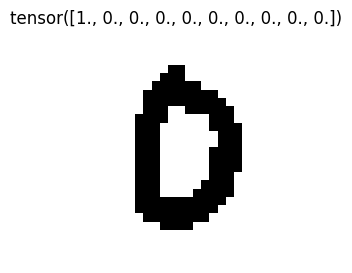

In [48]:
import matplotlib.pyplot as plt

figure = plt.figure(figsize=(3, 3))
sample_idx = torch.randint(len(train_dataset), size=(1,)).item()
img, label = train_dataset[sample_idx]
plt.title(label)
plt.axis("off")
plt.imshow(img.squeeze(), cmap="gray")
plt.show()

**Tensorflow data preprocessing**

In [ ]:
from sklearn.preprocessing import OneHotEncoder
mnist = keras.datasets.mnist.load_data(path="mnist.npz")
(X_train_full, y_train_full), (X_test, y_test) = mnist
#Images are turned from gray scale to binary scale in accordance to the chip established capabilities
X_train_full = (X_train_full < 127).astype(np.uint8)
X_test_full = (X_test < 127).astype(np.uint8)
#Training and test data are shrunk down for training speed reasons
X_train = X_train_full[:30000]
y_train = y_train_full[:30000]
X_test = X_test[:2000]
y_test = y_test[:2000]
#Due to the multiclass classification problem, labels are One Hot Encoded to translate the associated strings into binary digits in a row matrix
oneh = OneHotEncoder(sparse_output=False)
y_train = np.array(y_train).reshape(-1, 1)
y_test = np.array(y_test).reshape(-1, 1)
y_htrain = oneh.fit_transform(y_train) 
y_htest = oneh.fit_transform(y_test)

NameError: name 'keras' is not defined

# Model architecture and training

The chosen architecture was completely based on the principes of the LeNet-5 designed by Yann LeCun. C5 and F6, a convolution layer and a fully connected layer were dropped to ensure a smaller model size do to higher dimensions they suggest. This architecture was chosen due to its robust capabilites to ahchieve very high accuracies (~99%) on the MNIST, as it was specifically designed for this purpose. The image ahead condenses the aforementioned architecture.

![Screenshot 2025-08-24 110113.png](<attachment:Screenshot 2025-08-24 110113.png>)
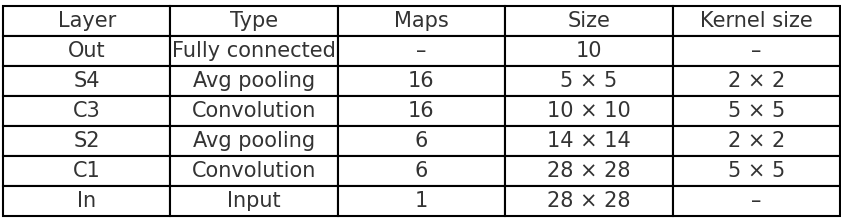

**The following table ilustrates the derived architecture**

![Screenshot 2025-08-24 110229.png](<attachment:Screenshot 2025-08-24 110229.png>)

- It can be visuallized in the following diagram if n = 6 and m = 16:

![Screenshot 2025-08-24 110401.png](<attachment:Screenshot 2025-08-24 110401.png>)
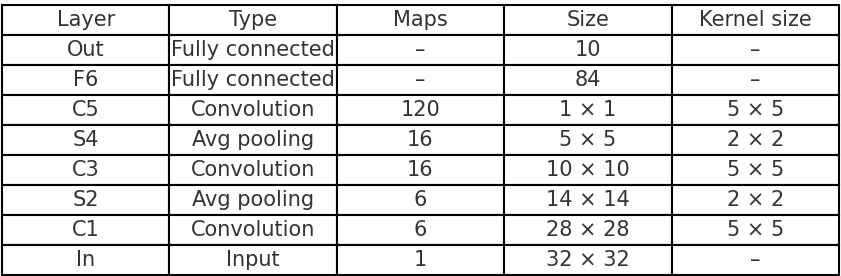
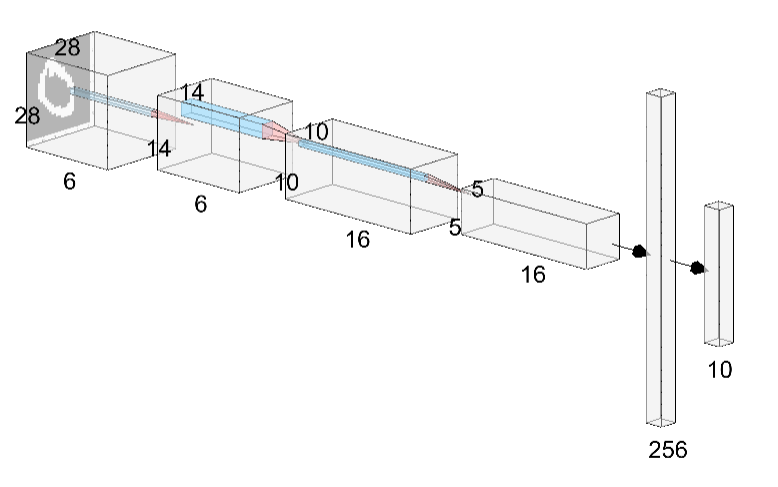

To determine what values to use for the number of maps n and m created by each convolution, the following methodology was established:
- **Training batch:** 10,000 images 
- **Test batch:** 2,000. 
- **Epochs per model:** 10
- **Loss function:** Categorical cross entropy 
- **Optimizer:** Stochastic gradient descent
- **Convolution layers activation function:** ReLu
- **Fully connected layer activation functions:** SoftMax.
- **Dependent variables:** Training accuracy, test accuracy and paramenter count
- **Independent variable:** n and m = n+10 being n the number of feature maps for the first convolution and m the number for the second convolution
- **Number of runs**: 10

In [ ]:
from functools import partial
data = []
for i in range(0,10):
    parameters = []
    train = []
    test = []
    
    for n in range(1,11):
        m = n+10
        DefaultConv2D = partial(layers.Conv2D, kernel_size=5, padding="same",
                                activation="relu")
        model = Sequential([
            DefaultConv2D(filters=n, kernel_size=5, input_shape=[28, 28, 1]),
            layers.MaxPool2D(pool_size=2, strides=2),
            DefaultConv2D(filters= m, kernel_size=5),
            layers.MaxPool2D(pool_size=2, strides=2),
            layers.Flatten(),
            layers.Dense(units=10, activation="softmax")
        ])

        model.compile(
            optimizer='sgd',
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )

        model.fit(X_train, y_htrain, epochs=10, batch_size=32)
        
        train_acc = model.evaluate(X_train, y_htrain)
        test_acc = model.evaluate(X_test, y_htest)
        params = model.count_params()
        
        parameters.append(params)
        train.append(train_acc[1])
        test.append(test_acc[1])
        
        data.append((parameters, train, test))


## Results

The intention here is to justify the model by analyzing its behavior thanks to the Monte Carlo approach intended to soften the consequences of the stochastic behaviour of weight initialization of the models

In [ ]:
#Organize the data into their respective number of filters
records = []
for run_id, (params, train_accs, test_accs) in enumerate(data):
    for i, p in enumerate(params):
        records.append({
            "run": run_id,
            "filters": i+1,
            "parameters": p,
            "train_accuracy": train_accs[i],
            "test_accuracy": test_accs[i]
        })

df = pd.DataFrame(records)


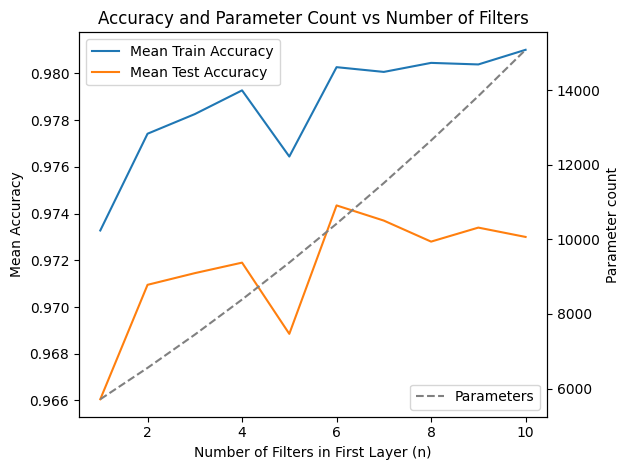

In [ ]:
import matplotlib.pyplot as plt

grouped = df.groupby("filters").mean()

fig, ax1 = plt.subplots()

# Accuracies
ax1.set_xlabel("Number of Filters in First Layer (n)")
ax1.set_ylabel("Mean Accuracy")
ax1.plot(grouped.index, grouped["train_accuracy"], label="Mean Train Accuracy")
ax1.plot(grouped.index, grouped["test_accuracy"], label="Mean Test Accuracy")
ax1.legend(loc="upper left")

# Parameter count
ax2 = ax1.twinx()
ax2.set_ylabel("Parameter count")
ax2.plot(grouped.index, grouped["parameters"], color="gray", linestyle="--", label="Parameters")
lines, labels = ax2.get_legend_handles_labels()
ax2.legend(lines, labels, loc="lower right")

ax1.set_title("Accuracy and Parameter Count vs Number of Filters")
plt.tight_layout()
plt.show()

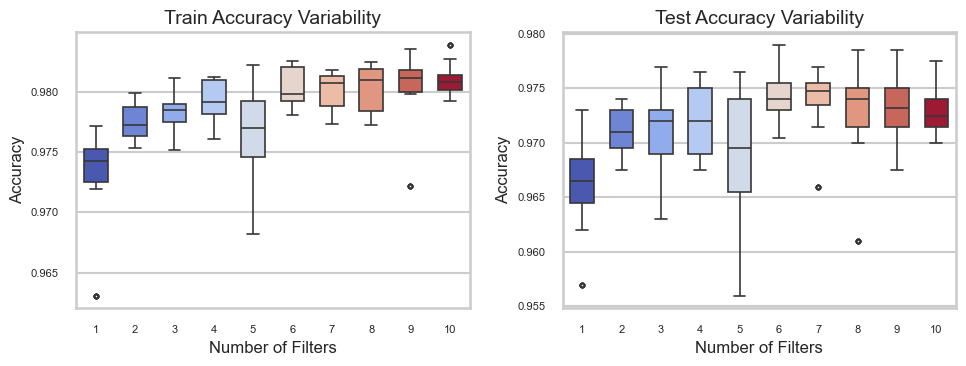

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# Train Accuracy Boxplot
sns.boxplot(x="filters", y="train_accuracy", hue="filters", data=df, ax=axes[0], palette="coolwarm",legend=False,width=0.6,linewidth=1.2,fliersize=3)
axes[0].set_title("Train Accuracy Variability", fontsize=14)
axes[0].set_xlabel("Number of Filters", fontsize=12)
axes[0].set_ylabel("Accuracy", fontsize=12)

# Test Accuracy Boxplot
sns.boxplot(x="filters", y="test_accuracy", hue="filters", data=df, ax=axes[1], palette="coolwarm",legend=False,width=0.6,linewidth=1.2,fliersize=3)
axes[1].set_title("Test Accuracy Variability", fontsize=14)
axes[1].set_xlabel("Number of Filters", fontsize=12)
axes[1].set_ylabel("Accuracy", fontsize=12)

for ax in axes:
    ax.tick_params(axis="x", labelsize=8)
    ax.tick_params(axis="y", labelsize=8) 

plt.tight_layout()
plt.show()


Without going to deep into the analysis, as the intention of the competition is oriented towards the IC and not data analysis, we will conclude over this data.

It is clear that there is a very subtle exponential relationship between the number of filters and the amount of parameters, yet, it definitely causes significant parameter surges as n is increased. On the other hand, the models proved to do a good job at classifying the 10 different classes as the test accuracies resembled that of the training accuracies, keeping a very remarkable global accuracy percentage with the test set of around 97%. 

In this sense, the variability of the accuracies shows what looks like a cap in performance after n = 6, the number proposed by Yann LeCun in his LeNet architecture. During these training iterations, the models with n = 6 performed slightly better than all the models below its filter number while it performed very similarly to those models with bigger n values. With this in mind, it is possible to associate the parameter count to the accuracy performance. Being a very close comparison, it is possible to say that the increase in parameters doesn't improve significantly the model accuracy specially after n = 6, which seems to be the optimal point for this value. Nevertheless, the capabilities of all the smaller models are still remarkable and worthwhile if the intention is to use the smallest model possible.

## Model quantization and training (Hardware oriented)

The following scheme represents how out CNN will work. To simulate as closely as possible on software, the idea was followed implementing a Quantization Aware Training (QAT) approach on the convolution layers.

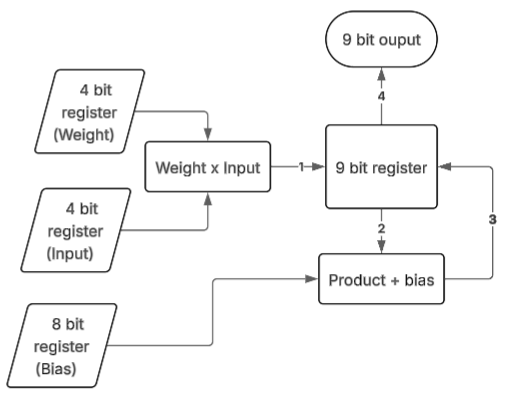

The result from the convolution layer is then passed to the ReLu activation layer which finishes the process as follows:

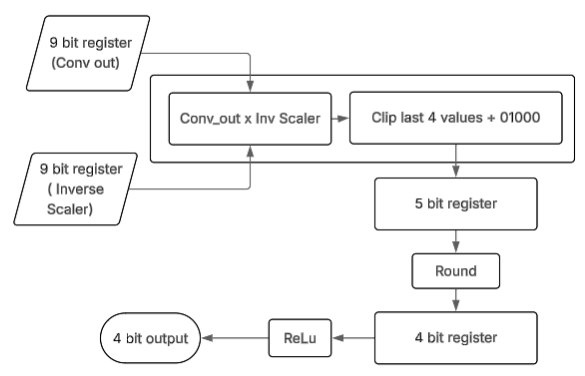

The specific register sizes were chosen to further reduce dimensions of the components without too costly performance tradeoffs. However, to extend the scope of the simulations, the same logic was followed using 2 bit weight quantization and 8 bit bias quantization to be able to visualize the behaviour of the operation using Netron interface as the Onnx library does not support 9 bit values for exports

**2-bit weight quantization, 8-bit bias quantization**

In [59]:
from brevitas.quant.scaled_int import Int8ActPerTensorFloat, Int8Bias
from torch.nn import Module
import torch.nn.functional as F
import torch
import brevitas.nn as qnn
   
class Int5ActPerTensorFloat(Int8ActPerTensorFloat):
    bit_width = 5
    
class Int2ActPerTensorFloat(Int8ActPerTensorFloat):
    bit_width = 2

class cnn_1(Module):
    def __init__(self):
        super(cnn_1, self).__init__()
        self.conv1 = qnn.QuantConv2d(1, 6, kernel_size=(5,5), 
                                     bias=True, 
                                     weight_bit_width=2, 
                                     bias_quant=Int8Bias, 
                                     input_quant=Int2ActPerTensorFloat, 
                                     output_quant=Int5ActPerTensorFloat,
                                     return_quant_tensor=True)
        self.relu1 = qnn.QuantReLU(bit_width=2, return_quant_tensor=True)
        self.conv2 = qnn.QuantConv2d(6, 16, kernel_size=(5,5), 
                                bias=True, 
                                weight_bit_width=2, 
                                bias_quant=Int8Bias,
                                input_quant=Int2ActPerTensorFloat, 
                                output_quant=Int5ActPerTensorFloat,
                                return_quant_tensor=True)
        self.fc1   = qnn.QuantLinear(16*4*4, 10, bias=True, weight_bit_width=2, bias_quant=Int8Bias)
    def forward(self, x):
        out = self.relu1(self.conv1(x))
        out = F.max_pool2d(out, kernel_size=(2,2),stride = 2)
        out = self.relu1(self.conv2(out))
        out = F.max_pool2d(out,kernel_size=(2,2),stride = 2)
        out = out.reshape(out.shape[0], -1)
        out = self.fc1(out)
        return out
qat_1_lenet = cnn_1()

**4-bit weight quantization, 8-bit bias quantization**

In [53]:
from brevitas.quant.scaled_int import Int8Bias, Int8ActPerTensorFloat
from torch.nn import Module
import torch.nn.functional as F
import torch
import brevitas.nn as qnn

class Int4ActPerTensorFloat(Int8ActPerTensorFloat):
    bit_width = 4
    
class Int9ActPerTensorFloat(Int8ActPerTensorFloat):
    bit_width = 9

class prueba_cnn(Module):
    def __init__(self):
        super(prueba_cnn, self).__init__()
        self.conv1 = qnn.QuantConv2d(1, 6, kernel_size=(5,5), 
                                     bias=True, 
                                     weight_bit_width=4, 
                                     bias_quant=Int8Bias, 
                                     input_quant=Int4ActPerTensorFloat, 
                                     output_quant=Int9ActPerTensorFloat,
                                     return_quant_tensor=True)
        self.relu1 = qnn.QuantReLU(bit_width=2, return_quant_tensor=True)
        self.conv2 = qnn.QuantConv2d(6, 16, kernel_size=(5,5), 
                                bias=True, 
                                weight_bit_width=4, 
                                bias_quant=Int8Bias,
                                input_quant=Int4ActPerTensorFloat, 
                                output_quant=Int9ActPerTensorFloat,
                                return_quant_tensor=True)
        self.fc1   = qnn.QuantLinear(16*4*4, 10, bias=True, weight_bit_width=4, bias_quant=Int8Bias)
    def forward(self, x):
        out = self.relu1(self.conv1(x))
        out = F.max_pool2d(out, kernel_size=(2,2),stride = 2)
        out = self.relu1(self.conv2(out))
        out = F.max_pool2d(out,kernel_size=(2,2),stride = 2)
        out = out.reshape(out.shape[0], -1)
        out = self.fc1(out)
        return out
qat_full_lenet = prueba_cnn()

**Step computations**

We can check the correct behavior of the convolutions and activations simply stepping a smaller random tensor through each layer.

In [41]:
vals = torch.randn(1, 1, 5, 5)
a = qat_full_lenet.conv1(vals).int()
b = qat_full_lenet.relu1(a).int()

import pandas as pd
if b.numel() < 20 and a.numel() < 20:
    df_a = pd.DataFrame(a.flatten().numpy(), columns=['d (9-bit)'])
    df_b = pd.DataFrame(b.flatten().numpy(), columns=['e (4-bit)'])
    comparison_df = pd.concat([df_a, df_b], axis=1)
    print("\n=== Tensor comparison ===")
    print(comparison_df)


=== Tensor comparison ===
   d (9-bit)  e (4-bit)
0       -103          0
1         95          3
2         81          3
3        -14          0
4       -256          0
5        -73          0


In [42]:
vals = torch.randn(1, 6, 5, 5)
d = qat_full_lenet.conv2(vals).int()
e = qat_full_lenet.relu1(d).int()

import pandas as pd
if d.numel() < 20 and e.numel() < 20:
    df_d = pd.DataFrame(d.flatten().numpy(), columns=['d (9-bit)'])
    df_e = pd.DataFrame(e.flatten().numpy(), columns=['e (4-bit)'])
    comparison_df = pd.concat([df_d, df_e], axis=1)
    print("\n=== Tensor comparison ===")
    print(comparison_df)



=== Tensor comparison ===
    d (9-bit)  e (4-bit)
0         -43          0
1          92          1
2         -29          0
3          17          0
4        -162          0
5         -43          0
6         171          2
7         -65          0
8         101          1
9         -45          0
10        255          3
11         86          1
12         15          0
13       -153          0
14        138          2
15         39          0


**Model training**

In [ ]:
learning_rate = 1e-3
epochs = 1
batch_size = 1000

def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * batch_size + len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
            


def test_loop(dataloader, model, loss_fn):
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0
    
    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()            
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

from torch import nn

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(qat_full_lenet.parameters(), lr=learning_rate)

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_loader, qat_full_lenet, loss_fn, optimizer)
    test_loop(test_loader, qat_full_lenet, loss_fn)
print("Done with qat_full_lenet")


loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(qat_1_lenet.parameters(), lr=learning_rate)

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_loader, qat_1_lenet, loss_fn, optimizer)
    test_loop(test_loader, qat_1_lenet, loss_fn)
print("Done with qat_1_lenet")

Epoch 1
-------------------------------
loss: 2.299853  [   64/60000]
loss: 1.136385  [100064/60000]
loss: 0.747950  [200064/60000]
loss: 0.546980  [300064/60000]
loss: 0.504718  [400064/60000]
loss: 0.453533  [500064/60000]
loss: 0.269123  [600064/60000]
loss: 0.255671  [700064/60000]
loss: 0.215476  [800064/60000]
loss: 0.121565  [900064/60000]
Test Error: 
 Accuracy: 93.7%, Avg loss: 0.203447 

Done!


In [62]:
from brevitas.export import export_onnx_qcdq

batch = next(iter(test_loader))
images, labels = batch

inp = images[:1]
print(f"Export input shape: {inp.shape}")

inp = images  

path = 'quant_model.onnx'

exported_model = export_onnx_qcdq(qat_1_lenet, args=inp, export_path=path, opset_version=13)  

Export input shape: torch.Size([1, 1, 28, 28])


**Brevitas and pytorch implementation visualization**

In [63]:
import netron
import time
from IPython.display import IFrame

def show_netron(model_path, port):
    time.sleep(3.)
    netron.start(model_path, address=("localhost", port), browse=False)
    return IFrame(src=f"http://localhost:{port}/", width="100%", height=400)

In [64]:
show_netron("quant_model.onnx", 8086)

Stopping http://localhost:8086
Serving 'quant_model.onnx' at http://localhost:8086


## Weight, biases and scaler extraction ##

All the values are extracted and converted to their respective bit width representation.

It is worth mentioning the strategy that will be used to quantize the 9 bit values in the ReLu layer. For this processes the inverse scaler value will be used to operate:

$ q = \mathcal{Q}\left(\text{input}, S_{\text{ReLU}}\right) = \text{round}\left(\frac{\text{input}}{S_{\text{ReLU}}}\right) $


where s_relu is the activation function scaler value, round approximates to the nearest integer and q is the final quantized value

In [78]:
import torch

qat_full_lenet.eval()

batch = next(iter(test_loader))
images, labels = batch

dummy_input = images[:1]

_ = qat_full_lenet(dummy_input)

params = {
    'conv1': {'weights': None, 'biases': None, 'scales': {}},
    'conv2': {'weights': None, 'biases': None, 'scales': {}},
    'fc1': {'weights': None, 'biases': None, 'scales': {}},
    'relu1': {'scales': {}}
}

for layer_name, layer in [('conv1', qat_full_lenet.conv1), ('conv2', qat_full_lenet.conv2), ('fc1', qat_full_lenet.fc1)]:
    
    params[layer_name]['weights'] = layer.quant_weight().int()
    
    params[layer_name]['biases'] = layer.quant_bias().int() if layer.bias is not None else None 
    
  
    params[layer_name]['scales'] = {
        'input': layer.input_quant.scale(), 
        'weight': layer.weight_quant.scale(),
        'output': layer.output_quant.scale(), 
        'bias': layer.bias_quant.scale() if layer.bias is not None else None
    }

params['relu1']['scales']['relu'] = qat_full_lenet.relu1.act_quant.scale().squeeze()

all_scales = []
for layer in params.values():
    all_scales.extend([s for s in layer['scales'].values() if s is not None])
all_scales = torch.stack([s.view(-1) for s in all_scales])
step_size = torch.max(torch.abs(all_scales)) / 127 
for layer_name in params:
    for scale_name in params[layer_name]['scales']:
        if params[layer_name]['scales'][scale_name] is not None:
            params[layer_name]['scales'][scale_name] = torch.round(params[layer_name]['scales'][scale_name] / step_size).clamp(-128, 127).int()

for layer_name in params:
    print(f"\n=== {layer_name.upper()} ===")
    print(f"Quantized Weights (4-bit): {params[layer_name].get('weights')}")
    print(f"Quantized Biases (8-bit): {params[layer_name].get('biases')}")
    print(f"Quantized Scales (8-bit): {params[layer_name]['scales']}")

relu_scale = params['relu1']['scales']['relu'].float() * step_size
inv_scale_fixed = torch.round(1.0 / relu_scale * (1 << 4)).clamp(-512, 511).int()
print(f"ReLU inv_scale_fixed (9-bit): {inv_scale_fixed}")


=== CONV1 ===
Quantized Weights (4-bit): tensor([[[[-7,  3, -6, -1, -4],
          [ 1, -5,  6,  3, -7],
          [ 2, -2, -6, -1,  5],
          [ 1, -3,  6,  7, -5],
          [-5,  4,  5, -1,  1]]],


        [[[-1, -7,  6, -6,  5],
          [ 1,  2, -5,  3, -2],
          [ 6, -2, -6, -4,  7],
          [-5,  0,  3, -4,  2],
          [ 4, -4,  3,  6, -4]]],


        [[[-2, -5, -7,  1, -3],
          [ 4,  1,  1,  0, -6],
          [ 7, -4, -2, -6, -6],
          [-3, -4, -1, -5, -5],
          [ 6,  3,  1,  6, -7]]],


        [[[-5,  0, -5,  2, -4],
          [ 5,  7,  2,  7,  0],
          [ 3,  7, -3,  4,  0],
          [-7,  2,  3, -6, -5],
          [-6, -2,  3,  5,  1]]],


        [[[-6, -7, -2, -6,  3],
          [ 3,  1,  4,  3, -6],
          [ 5, -6,  2, -3, -1],
          [-2, -2,  6, -5, -5],
          [ 3,  0, -4, -6, -3]]],


        [[[-1, -6, -2, -2,  6],
          [ 1, -6, -2, -7,  6],
          [ 1,  1,  3, -1, -4],
          [-4,  6,  5, -3,  5],
          

## Future work

The trained models and the hardware approximation proves to hold on to high (>90%) accuracies while using the intended quantization. It additionally yields the required values for our weights, biases and scalers which are essential for our IC implementation. However, the quantization has not been yet applied on the Fully Connected layer which represents a bigger challenge for our register usage in the IC. Additionally, we intend to close the gap even further between the software implementation and our IC implementation by lauching a number of simulations that allow us to compare the effect of signed and unsigned values for biases and weights, the symmetry of the quantization for each layer and the usage of lower bit counts for all the parameters intending to lower spacial usage. 

# References

- Géron, A. (2022). Hands-on machine learning with Scikit-Learn, Keras, and TensorFlow (3rd ed.). O'Reilly Media.
- Y. Lecun, L. Bottou, Y. Bengio and P. Haffner, "Gradient-based learning applied to document recognition," in Proceedings of the IEEE, vol. 86, no. 11, pp. 2278-2324, Nov. 1998, doi: 10.1109/5.726791.
- MNIST dataset: https://www.kaggle.com/datasets/hojjatk/mnist-dataset?select=train-images.idx3-ubyte
- Xilinx, "Brevitas: Quantization-aware training in PyTorch," GitHub repository, 2021. [Online]. Available: https://github.com/Xilinx/brevitas
- PyTorch Team, "PyTorch: Tensors and Dynamic neural networks in Python with strong GPU acceleration," 2019. [Online]. Available: https://pytorch.org/
- Google, "TensorFlow: An end-to-end open source machine learning platform," 2015. [Online]. Available: https://www.tensorflow.org/
